In [2]:
import threading
import torch
import pickle
import io
from time import time
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import scipy.stats
import pandas as pd
import glob
import cv2
import binary_fractions
import struct
from torch import nn, rand
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torchvision import datasets, transforms
from torchvision.models import Inception_V3_Weights, inception_v3
from torchsummary import summary
from inception import mi

Predefined values

In [3]:
DTYPE = torch.float32

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

Preparing Dataset 

In [ ]:
INPUT_PATH = '/kaggle/input/imagenet1k0'

transform = transforms.Compose([
    transforms.ToTensor(),
    Inception_V3_Weights.IMAGENET1K_V1.transforms(),
])

testset = datasets.ImageFolder(
    root=INPUT_PATH,
    transform=transform,
)

testloader = DataLoader(
    dataset=testset,
    batch_size=100,
    shuffle=False,
)

In [11]:
class ImageNet1kValid(Dataset):
  def __init__(self, imgs_path: str, per_class: int=50):
    self.device = DEVICE
    self.dtype = DTYPE
    self.transform = Inception_V3_Weights.IMAGENET1K_V1.transforms()
    self.dtype_transform = transforms.ConvertImageDtype(dtype=self.dtype)
    self.imgs_path = imgs_path
    self.folders_list = sorted(glob.glob(self.imgs_path + '*'))
    self.data = []

    def make_img_tensor(class_path):
      class_num =  int(class_path.split('/')[-1])
      class_num = torch.tensor([class_num]).squeeze()
      for img_path in sorted(glob.glob(class_path + '/*.jpg'))[:per_class]:
        img_tensor = torch.from_numpy(cv2.imread(img_path))
        img_tensor = img_tensor.to(self.device)
        img_tensor = img_tensor.permute(2, 0, 1)
        img_tensor = self.dtype_transform(img_tensor)
        img_tensor = self.transform(img_tensor)
        self.data.append([img_tensor, class_num])
    
    for i in range(0, 10):
      ths = []
      for class_path in self.folders_list[i*100:(i+1)*100]:
        th = threading.Thread(target=make_img_tensor, args=(class_path,))
        ths.append(th)
        th.start()
      for th in ths:
        th.join()

  def to_type(self, dtype):
    self.dtype = dtype
    self.dtype_transform = transforms.ConvertImageDtype(dtype=self.dtype)
    for i in range(len(self.data)):
      self.data[i][0] = self.dtype_transform(self.data[i][0])

  def change_order(self, order_list: list):
    order_of_keys = {}
    for i in self.data:
        order_of_keys[i[1].item()] = i
    new_data = []
    for i in order_list:
      new_data.append(order_of_keys[i])
    self.data = new_data
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
testset = ImageNet1kValid(imgs_path='./imagenet/', per_class=1)
print(testset.__len__())

In [14]:
torch.save(testset, './inception/perclass1_16.pth')

In [12]:
testset = torch.load('./inception/perclass1_32.pth')

In [13]:
testloader = DataLoader(
    dataset=testset,
    batch_size=100,
    shuffle=False,
)

Inception Model

In [ ]:
inception = mi.m_inception_v3(weights=mi.Inception_V3_Weights.IMAGENET1K_V1)
# summary(inception, (3, 299, 299))
# inception.parameters

In [21]:
if DTYPE == torch.bfloat16:
    inception.bfloat16()
elif DTYPE == torch.float32:
    inception.float()
inception = inception.to(DEVICE)

In [27]:
def main_test(inception, testloader):
  inception.eval()
  with torch.no_grad():
    predictions = torch.tensor([], dtype=torch.int, device=DEVICE)
    scores = torch.tensor([], device=DEVICE)
    for X, y in testloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      pred = inception(X)
      probs = nn.functional.softmax(pred, dim=1)
      output = torch.sort(probs, dim=1, descending=True)
      predictions = torch.cat((predictions, output[1]))
      scores = torch.cat((scores, output[0]))
    return (predictions, scores)

main_data_16 = main_test(inception, testloader)


In [47]:
main_data = pd.Series({
    'float32': main_data_32,
    'bfloat16': main_data_16,
})
main_data.to_pickle('./inception/inception_main_data.pkl')

In [5]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./inception/inception_main_data.pkl', 'rb') as f:
    main_data = CPU_Unpickler(f).load()


Fault Injection and Testing

In [10]:
class BinaryParam:
    def __init__(self, number: torch.Tensor=torch.tensor(0, dtype=DTYPE, device=DEVICE)):
        self.number = number
        self.number_type = number.dtype
        if self.number_type == torch.bfloat16:
            self.conversion_types = ['FP16']
            self.default_conversion = 'FP16'
        elif self.number_type == torch.float32:
            self.conversion_types = ['FP32', 'FX32']
            self.default_conversion = 'FP32'

    def to_binary(self, conversion_type: str=None) -> str:
        if conversion_type is None:
            conversion_type = self.default_conversion
        if conversion_type not in self.conversion_types:
            raise TypeError('{} to {} conversion does not possible'.format(self.number_type, conversion_type))
        if conversion_type == 'FP16':
            return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', self.number.item())[:2])
        elif conversion_type == 'FP32':
            return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', self.number.item()))
        elif conversion_type == 'FX32':
            fx32_twos = binary_fractions.Binary(self.number.item()).to_twoscomplement()
            fx32_temp = binary_fractions.Binary(str(fx32_twos)).string.split('.')
            fx32_l = fx32_temp[0]
            fx32_lfilled = ''.join('{}'.format(fx32_l[0]) for i in range(10 - len(fx32_l))) + fx32_l[-10:]
            fx32_binary = fx32_lfilled + fx32_temp[1][:22]
            return fx32_binary
    
    def to_decimal(self, binary_str: tuple) -> torch.Tensor:
        if binary_str[1] not in self.conversion_types:
            raise TypeError('{} to {} conversion does not possible'.format(binary_str, self.number_type))
        if binary_str[1] == 'FP16':
            buffer = int(binary_str[0] + ''.zfill(16), 2).to_bytes(4, 'big')
            return self.number.fill_(struct.unpack('>f', buffer)[0])
        elif binary_str[1] == 'FP32':
            buffer = int(binary_str[0], 2).to_bytes(4, 'big')
            return self.number.fill_(struct.unpack('>f', buffer)[0])
        elif binary_str[1] == 'FX32':
            fx32_twos = binary_str[0][:10] + '.' + binary_str[0][10:]
            return self.number.fill_(binary_fractions.TwosComplement(fx32_twos).to_float())


In [6]:
def fault_injector(inception, conversion_type: str, selected_param: int=None, selected_bit: int=None):
    params_vector = parameters_to_vector(inception.parameters())
    if selected_param is None:
        selected_param = round(rand(1).item() * (len(params_vector) - 1))

    main_param = params_vector[selected_param].item()
    bi_param = BinaryParam(params_vector[selected_param])
    bi_str = bi_param.to_binary(conversion_type)
    if selected_bit is None:
        selected_bit = round(rand(1).item() * (len(bi_str) - 1))
    new_bi_str = list(bi_str)
    new_bi_str[selected_bit] = '1' if bi_str[selected_bit] == '0' else '0'
    new_bi_str = ''.join(new_bi_str)
    injected_param = bi_param.to_decimal((new_bi_str, conversion_type)).item()
    
    injected_inception = mi.m_inception_v3(weights=mi.Inception_V3_Weights.IMAGENET1K_V1)
    if DTYPE == torch.bfloat16:
        injected_inception.bfloat16()
    elif DTYPE == torch.float32:
        injected_inception.float()
    injected_inception = injected_inception.to(DEVICE)
    vector_to_parameters(vec=params_vector, parameters=injected_inception.parameters())

    return injected_inception, main_param, injected_param


In [7]:
def test(inception, testloader):
  inception.eval()
  with torch.no_grad():
    predictions = torch.tensor([], dtype=torch.int, device=DEVICE)
    scores = torch.tensor([], device=DEVICE)
    for X, y in testloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      pred = inception(X)
      probs = nn.functional.softmax(pred, dim=1)
      output = torch.max(probs, 1)
      predictions = torch.cat((predictions, output[1]))
      scores = torch.cat((scores, output[0]))
    return (predictions, scores)
          

In [ ]:
params = list(inception.state_dict().values())
layers_length = []
for layer in range(len(params)):
    layers_length.append(list(params[layer].flatten().size())[0])
total_params = sum(layers_length)
cumulative_length = np.cumsum(layers_length)

layers_iteration = OrderedDict()
layer = 0
for sdc_number in range(100):
    start_layer = layer
    while layer < len(layers_length) and cumulative_length[layer] <= (sdc_number + 1) * total_params / 100:
        layer += 1
    if layer >= len(layers_length):
        layer -= 1
    chosed_layer = np.random.choice(np.arange(start_layer, layer + 1), 1)[0]
    if chosed_layer == 0:
        start_param = 0
    else:
        start_param = int(cumulative_length[chosed_layer - 1])
    end_param = int(cumulative_length[chosed_layer])
    if chosed_layer not in layers_iteration.keys():
        layers_iteration[chosed_layer] = [(start_param, end_param), 1]
    else:
        layers_iteration[chosed_layer][1] += 1


In [ ]:
with open('./inception/inception_chosen_layers.pkl', 'wb') as handle:
    pickle.dump(layers_iteration, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('./inception/inception_chosen_layers.pkl', 'rb') as handle:
    layers_iteration = pickle.load(handle)


In [12]:
injected_data = pd.DataFrame(columns=['dtype', 'layer', 'param_number', 'bit_position', 'before_value', 'after_value', 'output'])

In [ ]:
conversion_type = 'FP16'
if conversion_type in ['FP32', 'FX32']:
    number_size = 32
elif conversion_type == 'FP16':
    number_size = 16

for layer in layers_iteration.keys():
    for param_number in np.random.choice(np.arange(layers_iteration[layer][0][0], layers_iteration[layer][0][1]), layers_iteration[layer][1], replace=False):
        for bit in range(number_size):
            start = time()
            injected_inception, before_value, after_value = fault_injector(inception, conversion_type, param_number, bit)
            output = test(injected_inception, testloader)
            info = {
                'dtype': conversion_type,
                'layer': layer,
                'param_number': param_number,
                'bit_position': bit,
                'before_value': before_value,
                'after_value': after_value,
                'output': output,
            }
            injected_data.loc[len(injected_data)] = info
            end = time()
            print('{:>0.4f}'.format((end - start)))


In [39]:
injected_data.to_pickle('./inception/inception_injected_data.pkl')

In [4]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./inception/inception_injected_data.pkl', 'rb') as f:
    injected_data = CPU_Unpickler(f).load()


In [38]:
injected_data.to_csv('./inception/inception_injected_data.csv')

In [ ]:
injected_data= pd.read_csv('./inception/inception_injected_data.csv')

In [12]:
print(injected_data.memory_usage(index=True).sum())
injected_data

697088


,dtype,layer,param_number,bit_position,before_value,after_value,output,sdc1,sdc5,sdc10p,sdc20p
0,FP32,17,29026,0,0.011188,-1.118778e-02,"([tensor(12), tensor(44), tensor(14), tensor(2...",0.1,0.0,0.0,0.0
1,FP32,17,29026,1,0.011188,3.807004e+36,"([tensor(916), tensor(111), tensor(916), tenso...",99.9,99.6,99.9,99.9
2,FP32,17,29026,2,0.011188,6.064908e-22,"([tensor(12), tensor(44), tensor(14), tensor(2...",0.1,0.0,0.0,0.0
3,FP32,17,29026,3,0.011188,2.604858e-12,"([tensor(12), tensor(44), tensor(14), tensor(2...",0.1,0.0,0.0,0.0
4,FP32,17,29026,4,0.011188,1.707120e-07,"([tensor(12), tensor(44), tensor(14), tensor(2...",0.1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7915,FP16,578,26271310,11,0.001335,1.457214e-03,"([tensor(12), tensor(44), tensor(14), tensor(2...",0.9,0.0,1.0,0.0
7916,FP16,578,26271310,12,0.001335,1.274109e-03,"([tensor(12), tensor(44), tensor(14), tensor(2...",0.9,0.0,1.0,0.0
7917,FP16,578,26271310,13,0.001335,1.304626e-03,"([tensor(12), tensor(44), tensor(14), tensor(2...",0.9,0.0,1.0,0.0
7918,FP16,578,26271310,14,0.001335,1.319885e-03,"([tensor(12), tensor(44), tensor(14), tensor(2...",0.9,0.0,1.0,0.0


SDCs calculation

In [4]:
def sdc1(injected_outputs: pd.Series, main_outputs: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()
    for injection, value in injected_outputs.items():
        sdcs[injection] = (value[0] != main_outputs[:, 0]).type(torch.float).sum().item() * 100 / testset_length
    return pd.Series(sdcs)

def sdc5(injected_outputs: pd.Series, main_outputs: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()

    for injection, value in injected_outputs.items():
        testset_check = 0
        for test in range(testset_length):
            if value[0][test] not in main_outputs[test, :5]:
                testset_check += 1
        testset_check = testset_check / testset_length
        sdcs[injection] = testset_check * 100
    
    return pd.Series(sdcs)

def sdc10p(injected_outputs: pd.Series, main_outputs: torch.Tensor, main_scores: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()

    for injection, value in injected_outputs.items():
        testset_check = 0
        for test in range(testset_length):
            index = (main_outputs[test] == value[0][test]).nonzero(as_tuple=True)[0]
            ratio = value[1][test] / main_scores[test, index]
            if ratio > 1.1 or ratio < 0.9:
                testset_check += 1
        testset_check = testset_check / testset_length
        sdcs[injection] = testset_check * 100

    return pd.Series(sdcs)

def sdc20p(injected_outputs: pd.Series, main_outputs: torch.Tensor, main_scores: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()

    for injection, value in injected_outputs.items():
        testset_check = 0
        for test in range(testset_length):
            index = (main_outputs[test] == value[0][test]).nonzero(as_tuple=True)[0]
            ratio = value[1][test] / main_scores[test, index]
            if ratio > 1.2 or ratio < 0.8:
                testset_check += 1
        testset_check = testset_check / testset_length
        sdcs[injection] = testset_check * 100
    
    return pd.Series(sdcs)

def sdc10p_20p(injected_outputs: pd.Series, main_outputs: torch.Tensor, main_scores: torch.Tensor):
    sdcs1 = {}
    sdcs2 = {}
    testset_length = main_outputs.__len__()

    for injection, value in injected_outputs.items():
        testset_check1 = 0
        testset_check2 = 0
        for test in range(testset_length):
            index = (main_outputs[test] == value[0][test]).nonzero(as_tuple=True)[0]
            ratio = value[1][test] / main_scores[test, index]
            if ratio > 1.1 or ratio < 0.9:
                testset_check1 += 1
            if ratio > 1.2 or ratio < 0.8:
                testset_check2 += 1
        testset_check1 = testset_check1 / testset_length
        testset_check2 = testset_check2 / testset_length
        sdcs1[injection] = testset_check1 * 100
        sdcs2[injection] = testset_check2 * 100
    
    return pd.Series(sdcs1), pd.Series(sdcs2)

In [ ]:
inception_sdc10p, inception_sdc20p = sdc10p_20p(injected_data['output'], main_data['bfloat16'][0], main_data['bfloat16'][1])


SDC probability confidence interval

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    length = len(a)
    mean, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., length-1)
    return mean, h


Total SDC probability plot

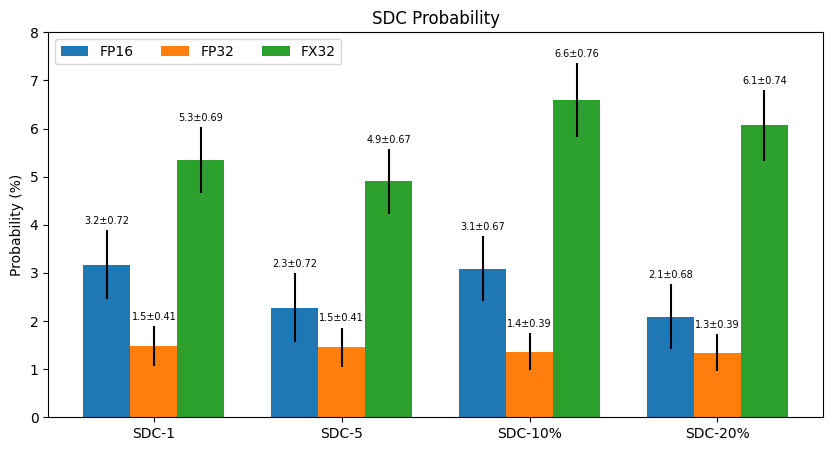

In [16]:
sdcs = {
    'FP16': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc20p']),
    ],
    'FP32': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc20p']),
    ],
    'FX32': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc20p']),
    ]
}

plt.figure(figsize=(10, 5))
plt.subplot()
width = 0.25

for i, (key, val) in enumerate(sdcs.items()):
    offset = width * i
    rects = plt.bar(np.arange(4) + offset, [m[0] for m in val], width, label=key, yerr=[np.round(m[1], 2) for m in val])
    plt.bar_label(rects, labels=['{}±{}'.format(np.round(m[0], 1), np.round(m[1], 2)) for m in val], fontsize=7, padding=3)

plt.ylabel('Probability (%)')
plt.title('SDC Probability')
plt.xticks(np.arange(4) + width, ['SDC-1', 'SDC-5', 'SDC-10%', 'SDC-20%'])
plt.legend(loc='upper left', ncols=3)
plt.ylim(0, 8)

plt.show()

Bit-wise SDC probability plot

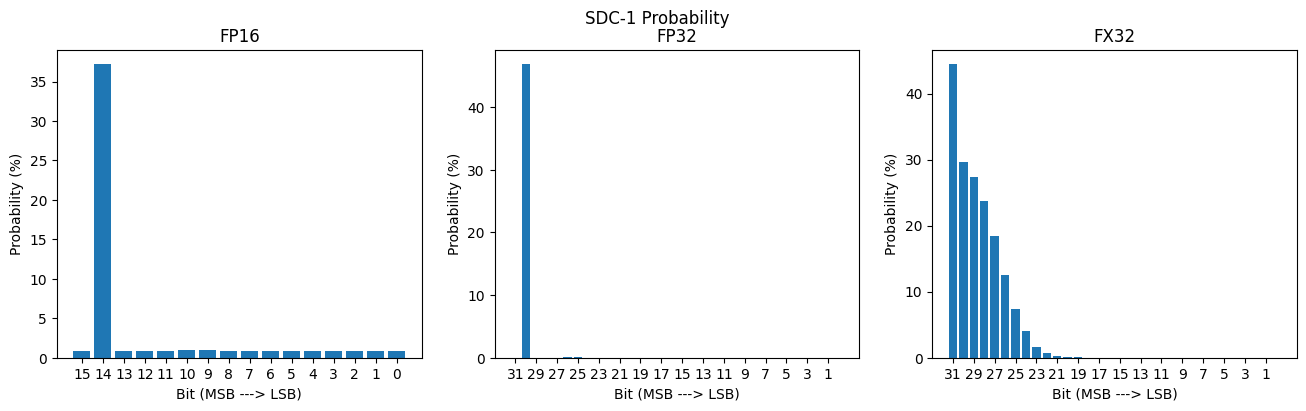

In [17]:
types_32 = np.arange(0, 32)
types_16 = np.arange(0, 16)
fp32_means = []
fx32_means = []
fp16_means = []
for i in types_32:
    mean_fp32_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FP32') & (injected_data['bit_position'] == i)]['sdc1'])
    fp32_means.append(mean_fp32_1)

    mean_fx32_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FX32') & (injected_data['bit_position'] == i)]['sdc1'])
    fx32_means.append(mean_fx32_1)

for i in types_16:
    mean_fp16_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FP16') & (injected_data['bit_position'] == i)]['sdc1'])
    fp16_means.append(mean_fp16_1)

plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title('FP16')
plt.bar((np.array(list(reversed(types_16)))).astype(str), fp16_means)
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')

plt.subplot(132)
plt.title('FP32')
plt.bar(types_32, fp32_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')

plt.subplot(133)
plt.title('FX32')
plt.bar(types_32, fx32_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')

plt.suptitle('SDC-1 Probability')
plt.show()


Layer-wise SDC probability plot

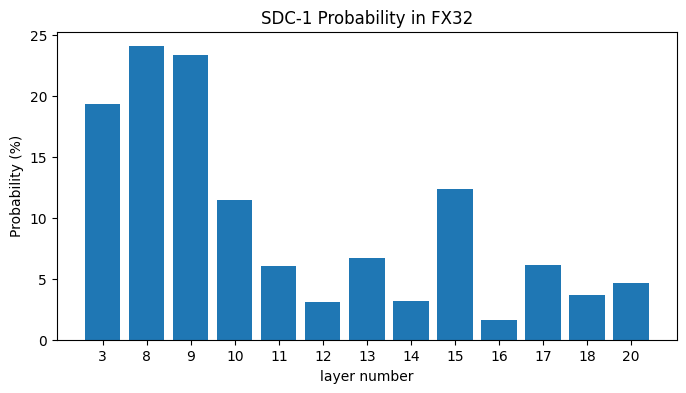

In [22]:
layers_param = layers_params_number(inception, [3, 299, 299])

total_layers = OrderedDict()
for key, bound in layers_param.items():
    new_key = key[1].split('.')[1]
    total_layers[new_key] = bound
    
fx32_means = OrderedDict()
prev_bound = 0
for i, (key, bound) in enumerate(total_layers.items()):
    selected = injected_data.loc[(injected_data['dtype'] == 'FX32') & (injected_data['param_number'] <= bound) & (injected_data['param_number'] >= prev_bound)]['sdc1']
    if len(selected.index) != 0:
        fx32_means[i+1] = mean_confidence_interval(selected)[0]
    prev_bound = bound

plt.figure(figsize=(8, 4))
plt.title('SDC-1 Probability in FX32')
layers_asstr = np.array(list(fx32_means.keys())).astype(str)
plt.bar(layers_asstr, fx32_means.values())
plt.xlabel('layer number')
plt.ylabel('Probability (%)')

plt.show()



Calculate range of layers

In [10]:
inception = mi.m_inception_v3(weights=mi.Inception_V3_Weights.IMAGENET1K_V1)
if DTYPE == torch.bfloat16:
    inception.bfloat16()
elif DTYPE == torch.float32:
    inception.float()
inception = inception.to(DEVICE)

In [10]:
def get_range_hooks(inception, outputs: OrderedDict, input_size: list):
    def get_range(layer):
        def hook(module, input, output):
            layer_output = output.detach().clone()
            layer_min = torch.min(layer_output, dim=0)[0]
            layer_max = torch.max(layer_output, dim=0)[0]
            if layer not in outputs.keys():
                outputs[layer] = torch.stack([layer_min, layer_max], dim=-1)
            else:
                total_min = torch.minimum(outputs[layer][..., 0], layer_min)
                total_max = torch.maximum(outputs[layer][..., 1], layer_max)
                outputs[layer] = torch.stack([total_min, total_max], dim=-1)
        return hook

    def get_layers_by_index(layer_name):
        def hook(module, input, output):
            indexed_layers[(len(indexed_layers), layer_name)] = module
        return hook
    
    def get_layers(name: str, model: torch.nn.Module):
        children = list(model.named_children())
        return [(name, model)] if len(children) == 0 else [ci for c in children for ci in get_layers(name + '.' + c[0], c[1])]
    
    indexed_layers = OrderedDict()
    layers = get_layers('inception', inception)
    hooks = []
    for (layer, module) in layers:
        hooks.append(module.register_forward_hook(get_layers_by_index(layer)))

    X = [torch.rand(2, *input_size).type(DTYPE).to(DEVICE)]

    inception.eval()
    with torch.no_grad():
        inception(*X)
    
    for hook in hooks:
        hook.remove()

    hooks = []
    for key, module in indexed_layers.items():
        hooks.append(module.register_forward_hook(get_range(key)))
    
    return hooks

In [11]:
def find_layers_range(inception, testloader, outputs = None):
    if outputs is None:
        outputs = OrderedDict()
    total = len(testloader.dataset)
    hooks = get_range_hooks(inception, outputs, [3, 299, 299])
    inception.eval()
    with torch.no_grad():
        for i, (X, _) in enumerate(testloader):
            X = X.to(DEVICE)
            inception(X)
            print("{} / {}".format(len(X) * (i + 1), total))
        for hook in hooks:
            hook.remove()
    return outputs

In [ ]:
params_range = find_layers_range(inception, testloader)

In [11]:
with open('./inception/inception_params_range.pkl', 'wb') as handle:
    pickle.dump(params_range, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./inception/inception_params_range.pkl', 'rb') as f:
    params_range = CPU_Unpickler(f).load()

SDC mitigation (Ranger)

In [8]:
inception = mi.m_inception_v3(weights=mi.Inception_V3_Weights.IMAGENET1K_V1)
if DTYPE == torch.bfloat16:
    inception.bfloat16()
elif DTYPE == torch.float32:
    inception.float()
inception = inception.to(DEVICE)

In [9]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./inception/inception_injected_data.pkl', 'rb') as f:
    injected_data = CPU_Unpickler(f).load()


In [26]:
def ranger(inception, params_range: OrderedDict, result, input_size: list):
    def set_range(layer):
        def hook(model, input, output):
            layer_output = output.detach().to(DEVICE)
            bounded_layer = layer_output.clone().to(DEVICE)
            params_range_min = params_range[layer][..., 0].to(DEVICE)
            params_range_max = params_range[layer][..., 1].to(DEVICE)
            
            bounded_layer = torch.maximum(bounded_layer, params_range_min)
            bounded_layer = torch.minimum(bounded_layer, params_range_max)

            # enable when you want sdc detection
            #check_sdc = torch.eq(torch.flatten(bounded_layer, 1), torch.flatten(layer_output, 1))
            #result[0] = torch.logical_and(result[0], torch.all(check_sdc, dim=1))
            
            return bounded_layer
        return hook
    
    def get_layers_by_index(layer_name):
        def hook(module: nn.Module, input, output):
            indexed_layers[(len(indexed_layers), layer_name)] = module
        return hook
    
    def get_layers(name: str, model: torch.nn.Module):
        children = list(model.named_children())
        return [(name, model)] if len(children) == 0 else [ci for c in children for ci in get_layers(name + '.' + c[0], c[1])]
    
    indexed_layers = OrderedDict()
    layers = get_layers('inception', inception)
    hooks = []
    for (layer, module) in layers:
        hooks.append(module.register_forward_hook(get_layers_by_index(layer)))

    X = [torch.rand(2, *input_size).type(DTYPE).to(DEVICE)]
    
    inception.eval()
    with torch.no_grad():
        inception(*X)
    
    for hook in hooks:
        hook.remove()
    
    registered = []
    for key in params_range.keys():
        if key[1].split('.')[-1] == 'relu':
            registered.append(key)
            
            next_key = list(params_range.keys())[key[0] + 1]
            if next_key[1].split('.')[-1] in ['maxpool', 'avgpool', 'maxpool1', 'maxpool2', 'maxpool3']:
                registered.append(next_key)
    registered.append(list(params_range.keys())[-1])

    hooks = []
    for key in registered:
        hooks.append(indexed_layers[key].register_forward_hook(set_range(key)))

    return hooks

In [15]:
def detector_forward(inception, testloader, batch_result):
    inception.eval()   
    with torch.no_grad():
        predictions = torch.tensor([], dtype=torch.int, device=DEVICE)
        scores = torch.tensor([], device=DEVICE)
        result = torch.tensor([], dtype=torch.bool, device=DEVICE)
        inf_time = 0
        for X, _ in testloader:
            batch_result[0] = torch.full((len(X),), True).to(DEVICE)
            X = X.to(DEVICE)
            start = time()
            pred = inception(X)
            inf_time += (time() - start)
            probs = nn.functional.softmax(pred, dim=1)
            output = torch.max(probs, 1)
            predictions = torch.cat((predictions, output[1]))
            scores = torch.cat((scores, output[0]))
            result = torch.cat((result, batch_result[0]))
        return (predictions, scores), result, inf_time

In [16]:
def detector_test(inception, testloader, injected_data, params_range, cushion):
    new_params_range = OrderedDict()
    for layer, params in params_range.items():
        layer_min = torch.add(params[..., 0], torch.abs(params[..., 0]), alpha=-cushion)
        layer_max = torch.add(params[..., 1], torch.abs(params[..., 1]), alpha=cushion)
        new_params_range[layer] = torch.stack([layer_min, layer_max], dim=-1)
    
    for layer, params in new_params_range.items():
        new_params_range[layer] = torch.tensor([torch.min(params[..., 0]), torch.max(params[..., 1])], dtype=DTYPE)
    
    detector_data = pd.DataFrame(columns=['output', 'detected', 'runtime'])
    for i, row in injected_data.iterrows():
        injected_inception, _, _ = fault_injector(inception, row['dtype'], row['param_number'], row['bit_position'])

        batch_result = [0]

        hooks = ranger(injected_inception, new_params_range, batch_result, [3, 299, 299])

        detector_data.at[i, 'output'], detector_data.at[i, 'detected'], detector_data.at[i, 'runtime'] = detector_forward(injected_inception, testloader, batch_result)        

        for hook in hooks:
            hook.remove()
        
        print("index: {}, SDC detected: {} %, runtime: {}".format(i, 100 * (1 - detector_data.at[i, 'detected'].sum().item() / len(testloader.dataset)), detector_data.at[i, 'runtime']))
    return detector_data
        

In [ ]:
ranger_output = detector_test(inception, testloader, injected_data[6336:], params_range, 0)

In [23]:
ranger_output.to_pickle('./inception/inception_ranger_test.pkl')

In [7]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./inception/inception_ranger_test.pkl', 'rb') as f:
    ranger_output = CPU_Unpickler(f).load()


SDC mitigation (FT-ClipAct)

In [64]:
inception = mi.m_inception_v3(weights=mi.Inception_V3_Weights.IMAGENET1K_V1)
if DTYPE == torch.bfloat16:
    inception.bfloat16()
elif DTYPE == torch.float32:
    inception.float()
inception = inception.to(DEVICE)

In [8]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./inception/inception_injected_data.pkl', 'rb') as f:
    injected_data = CPU_Unpickler(f).load()

In [11]:
def layers_params_number(inception, input_size: list):
    def get_layers_by_index(layer_name):
        def hook(module, input, output):
            total = 0
            for value in module.state_dict().values():
                total += torch.flatten(value).__len__()
            if layer_name.split('.')[1] == 'AuxLogits':
                aux_params_number[0] += total
            else:
                indexed_layers[(len(indexed_layers), layer_name)] = total + aux_params_number[0]
                aux_params_number[0] = 0

        return hook
    
    def get_layers(name: str, model: nn.Module):
        children = list(model.named_children())
        return [(name, model)] if len(children) == 0 else [ci for c in children for ci in get_layers(name + '.' + c[0], c[1])]
    
    indexed_layers = OrderedDict()
    aux_params_number = [0]
    layers = get_layers('inception', inception)
    hooks = []
    for (layer, module) in layers:
        hooks.append(module.register_forward_hook(get_layers_by_index(layer)))

    X = [torch.rand(2, *input_size).type(DTYPE).to(DEVICE)]
    
    inception.train()
    with torch.no_grad():
        inception(*X)
    
    for hook in hooks:
        hook.remove()

    params_number = OrderedDict()
    for key in indexed_layers.keys():
        if key[1].split('.')[-1] == 'relu':
            params_number[key] = sum(list(indexed_layers.values())[:key[0]+1])
            
            next_key = list(indexed_layers.keys())[key[0] + 1]
            if next_key[1].split('.')[-1] in ['maxpool', 'avgpool', 'maxpool1', 'maxpool2', 'maxpool3']:
                params_number[next_key] = sum(list(indexed_layers.values())[:next_key[0]+1])
    params_number[list(indexed_layers.keys())[-1]] = sum(list(indexed_layers.values()))

    return params_number

In [31]:
def bound_activations(inception, params_range: OrderedDict, result, input_size: list):
    def set_range(layer):
        def hook(model, input, output):
            layer_output = output.detach().to(DEVICE)
            bounded_layer = layer_output.clone().to(DEVICE)
            params_range_min = params_range[layer][..., 0].to(DEVICE)
            params_range_max = params_range[layer][..., 1].to(DEVICE)

            bounded_layer[bounded_layer < params_range_min] = params_range_min
            bounded_layer[bounded_layer > params_range_max] = params_range_min

            # enable when you want sdc detection
            # check_sdc = torch.eq(torch.flatten(bounded_layer, 1), torch.flatten(layer_output, 1))
            # result[0] = torch.logical_and(result[0], torch.all(check_sdc, dim=1))
            
            return bounded_layer
        return hook
    
    def get_layers_by_index(layer_name):
        def hook(module: nn.Module, input, output):
            indexed_layers[(len(indexed_layers), layer_name)] = module
        return hook
    
    def get_layers(name: str, model: torch.nn.Module):
        children = list(model.named_children())
        return [(name, model)] if len(children) == 0 else [ci for c in children for ci in get_layers(name + '.' + c[0], c[1])]
    
    indexed_layers = OrderedDict()
    layers = get_layers('inception', inception)
    hooks = []
    for (layer, module) in layers:
        hooks.append(module.register_forward_hook(get_layers_by_index(layer)))

    X = [torch.rand(2, *input_size).type(DTYPE).to(DEVICE)]
    
    inception.eval()
    with torch.no_grad():
        inception(*X)
    
    for hook in hooks:
        hook.remove()
    
    registered = []
    for key in params_range.keys():
        if key[1].split('.')[-1] == 'relu':
            registered.append(key)
            
            next_key = list(params_range.keys())[key[0] + 1]
            if next_key[1].split('.')[-1] in ['maxpool', 'avgpool', 'maxpool1', 'maxpool2', 'maxpool3']:
                registered.append(next_key)
    registered.append(list(params_range.keys())[-1])

    hooks = []
    for key in registered:
        hooks.append(indexed_layers[key].register_forward_hook(set_range(key)))

    return hooks

In [32]:
def detector_forward(inception, testloader, batch_result):
    inception.eval()   
    with torch.no_grad():
        predictions = torch.tensor([], dtype=torch.int, device=DEVICE)
        scores = torch.tensor([], device=DEVICE)
        if batch_result is None:
            inf_time = 0
            for i, (X, _) in enumerate(testloader):
                X = X.to(DEVICE)
                start = time()
                pred = inception(X)
                inf_time += (time() - start)
                probs = nn.functional.softmax(pred, dim=1)
                output = torch.max(probs, 1)
                predictions = torch.cat((predictions, output[1]))
                scores = torch.cat((scores, output[0]))
                if i == 1:
                    break
            return (predictions, scores), inf_time
        else:
            result = torch.tensor([], dtype=torch.bool, device=DEVICE)
            inf_time = 0
            for X, _ in testloader:
                batch_result[0] = torch.full((len(X),), True).to(DEVICE)
                X = X.to(DEVICE)
                start = time()
                pred = inception(X)
                inf_time += (time() - start)
                probs = nn.functional.softmax(pred, dim=1)
                output = torch.max(probs, 1)
                predictions = torch.cat((predictions, output[1]))
                scores = torch.cat((scores, output[0]))
                result = torch.cat((result, batch_result[0]))
            return (predictions, scores), result, inf_time

In [18]:
def select_injection(inception, injected_data, ranger_data, layer_key):
    params_number = layers_params_number(inception, [3, 299, 299])
    possible_injections = injected_data[injected_data['param_number'] <= params_number[layer_key]]['param_number'].drop_duplicates().index.tolist()
    selected = []
    for key in possible_injections:
        for i in range(32):
            if injected_data.at[key+i, 'sdc1'] > 50 and abs(ranger_data.at[key+i, 'sdc1'] - injected_data.at[key+i, 'sdc1']) > 10:
                selected.append(key)
                break
    if len(selected) == 0:
        return None
    elif len(selected) < 4:
        return [key + i for key in selected for i in range(0, 32, 2)]
    else:
        rand_choice = np.random.choice(selected, 4, replace=False).tolist()
        return [key + i for key in rand_choice for i in range(0, 32, 2)]

In [19]:
def accuracy_calc(inception, testloader, injected_data, main_data, params_range, injections):
    outputs = pd.Series()
    for i in injections:
        injected_inception, _, _ = fault_injector(inception, injected_data.at[i, 'dtype'], injected_data.at[i, 'param_number'], injected_data.at[i, 'bit_position'])
        
        hooks = bound_activations(injected_inception, params_range, None, [3, 299, 299])
        
        outputs[i], _ = detector_forward(injected_inception, testloader, None)

        for hook in hooks:
            hook.remove()
    return sdc1(outputs, main_data['float32'][0][:200])
        

In [20]:
def fine_tuner(inception, testloader, injected_data, ranger_data, main_data, params_range, layers_key, N, M, D):
    new_params_range = OrderedDict()
    for layer, params in params_range.items():
        new_params_range[layer] = torch.tensor([torch.tensor(0, dtype=DTYPE), torch.max(params[..., 1])])

    injections = select_injection(inception, injected_data, ranger_data, layers_key[0])
    print('injections: {}'.format(injections))
    if injections is None:
        return new_params_range, [new_params_range[layer_key][1] for layer_key in layers_key]
    else:
        for counter in range(N):
            if counter == 0:
                S = [(torch.tensor(0, dtype=DTYPE), new_params_range[layer_key][1]) for layer_key in layers_key]

            else:
                if best_index == 3:
                    S = [(T[2][i], T[3][i]) for i in range(len(layers_key))]
                elif best_index == 0:
                    S = [(T[0][i], T[1][i]) for i in range(len(layers_key))]
                else:
                    S = [(T[best_index - 1][i], T[best_index + 1][i]) for i in range(len(layers_key))]
            
            T = [[t[0] for t in S]]
            T.append([T[0][i] + (S[i][1] - S[i][0]) / 3 for i in range(len(S))])
            T.append([T[1][i] + (S[i][1] - S[i][0]) / 3 for i in range(len(S))])
            T.append([S[i][1] for i in range(len(S))])
            SDC = []
            for t in T:
                temp_params_range = new_params_range.copy()
                for i, value in enumerate(t):
                    temp_params_range[layers_key[i]] = torch.tensor([0, value], dtype=DTYPE)
                temp_sdc = accuracy_calc(inception, testloader, injected_data, main_data, temp_params_range, injections)
                SDC.append(temp_sdc.mean())
            best_index = len(SDC) - 1 - np.argmin(list(reversed(SDC)))
            final_T = T[best_index]

            diff = []
            for i in range(3):
                diff.append(abs(SDC[i + 1] - SDC[i]))
            print('counter: {}\nTs: {}\nSDCs: {}\ndifferences: {}'.format(counter, T, SDC, diff))
            
            if max(diff) <= D and counter + 1 >= M:
                final_params_range = new_params_range.copy()
                for i, value in enumerate(final_T):
                        final_params_range[layers_key[i]] = torch.tensor([0, value], dtype=DTYPE)
                return final_params_range, final_T
        final_params_range = new_params_range.copy()
        for i, value in enumerate(final_T):
            final_params_range[layers_key[i]] = torch.tensor([0, value], dtype=DTYPE)
        return final_params_range, final_T


In [ ]:
layers_key = list(layers_params_number(inception, [3, 299, 299]).keys())
batch_layers = OrderedDict({key[1].split('.')[1]: [] for key in layers_key})

for key in layers_key:
    batch_layers[key[1].split('.')[1]].append(key)

tuned_layers = OrderedDict()
tuned_params_range = params_range
for batch, keys in batch_layers.items():
    print('batch {}'.format(batch))
    start= time()
    tuned_params_range, final_t = fine_tuner(inception, testloader, injected_data[3168:6336], ranger_output, main_data, tuned_params_range, keys, 4, 1, 0.2)
    for i, key in enumerate(keys):
        tuned_layers[key] = final_t[i]
    print('final_T: {}\nruntime: {} \n'.format(final_t, time() - start))
    

In [ ]:
with open('./inception/inception_tuned_params_range.pkl', 'wb') as handle:
    pickle.dump(tuned_params_range, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./inception/inception_tuned_params_range.pkl', 'rb') as f:
    tuned_params_range = CPU_Unpickler(f).load()

In [34]:
def detector_test(inception, testloader, injected_data, params_range):

    new_params_range = OrderedDict()
    for layer, params in params_range.items():
        new_params_range[layer] = torch.tensor([torch.min(params[..., 0]), torch.max(params[..., 1])], dtype=DTYPE)
    
    detector_data = pd.DataFrame(columns=['output', 'detected', 'runtime'])
    for i, row in injected_data.iterrows():
        injected_inception, _, _ = fault_injector(inception, row['dtype'], row['param_number'], row['bit_position'])

        batch_result = [0]

        hooks = bound_activations(injected_inception, new_params_range, batch_result, [3, 299, 299])

        detector_data.at[i, 'output'], detector_data.at[i, 'detected'], detector_data.at[i, 'runtime'] = detector_forward(injected_inception, testloader, batch_result)        

        for hook in hooks:
            hook.remove()
        
        print("index: {}, SDC detected: {} %, runtime: {}".format(i, 100 * (1 - detector_data.at[i, 'detected'].sum().item() / len(testloader.dataset)), detector_data.at[i, 'runtime']))
    return detector_data
        

In [ ]:
clipact_output = detector_test(inception, testloader, injected_data[6336:], tuned_params_range)

In [57]:
clipact_output.to_pickle('./inception/inception_clipact_test.pkl')

In [9]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=DEVICE)
        else: return super().find_class(module, name)

with open('./inception/inception_clipact_test.pkl', 'rb') as f:
    clipact_output = CPU_Unpickler(f).load()

Compare two algorithms

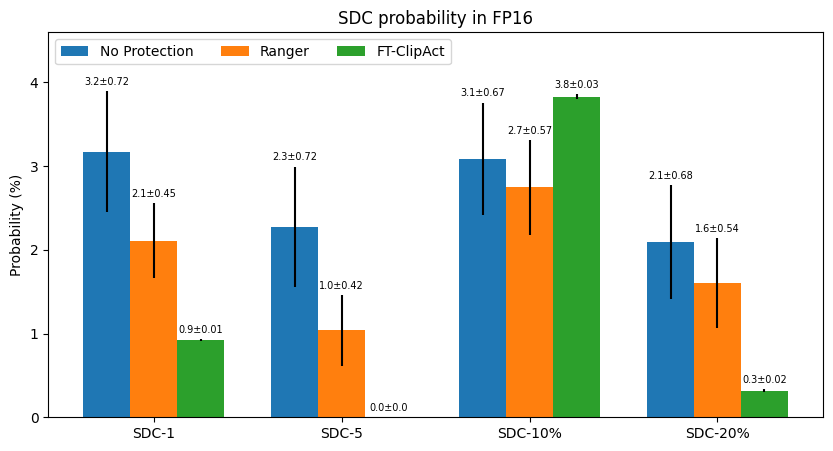

In [12]:
sdcs = {
    'No Protection': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP16']['sdc20p']),
    ],
    'Ranger': [
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FP16']['sdc1']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FP16']['sdc5']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FP16']['sdc10p']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FP16']['sdc20p']),
    ],
    'FT-ClipAct': [
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FP16']['sdc1']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FP16']['sdc5']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FP16']['sdc10p']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FP16']['sdc20p']),
    ]
}

plt.figure(figsize=(10, 5))
plt.subplot()
width = 0.25

for i, (key, val) in enumerate(sdcs.items()):
    offset = width * i
    rects = plt.bar(np.arange(4) + offset, [m[0] for m in val], width, label=key, yerr=[np.round(m[1], 2) for m in val])
    plt.bar_label(rects, labels=['{}±{}'.format(np.round(m[0], 1), np.round(m[1], 2)) for m in val], fontsize=7, padding=3)

plt.ylabel('Probability (%)')
plt.title('SDC probability in FP16')
plt.xticks(np.arange(4) + width, ['SDC-1', 'SDC-5', 'SDC-10%', 'SDC-20%'])
plt.legend(loc='upper left', ncols=3)
plt.ylim(0, 4.6)

plt.show()

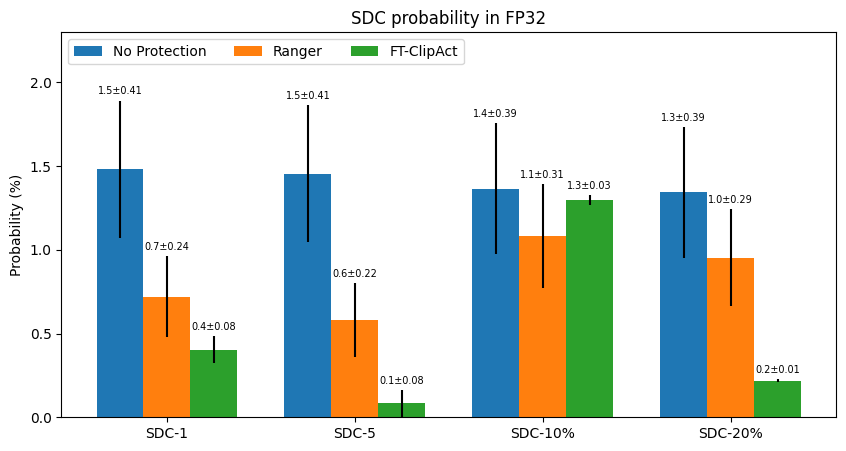

In [13]:
sdcs = {
    'No Protection': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FP32']['sdc20p']),
    ],
    'Ranger': [
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FP32']['sdc1']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FP32']['sdc5']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FP32']['sdc10p']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FP32']['sdc20p']),
    ],
    'FT-ClipAct': [
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FP32']['sdc1']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FP32']['sdc5']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FP32']['sdc10p']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FP32']['sdc20p']),
    ]
}

plt.figure(figsize=(10, 5))
plt.subplot()
width = 0.25

for i, (key, val) in enumerate(sdcs.items()):
    offset = width * i
    rects = plt.bar(np.arange(4) + offset, [m[0] for m in val], width, label=key, yerr=[np.round(m[1], 2) for m in val])
    plt.bar_label(rects, labels=['{}±{}'.format(np.round(m[0], 1), np.round(m[1], 2)) for m in val], fontsize=7, padding=3)

plt.ylabel('Probability (%)')
plt.title('SDC probability in FP32')
plt.xticks(np.arange(4) + width, ['SDC-1', 'SDC-5', 'SDC-10%', 'SDC-20%'])
plt.legend(loc='upper left', ncols=3)
plt.ylim(0, 2.3)

plt.show()

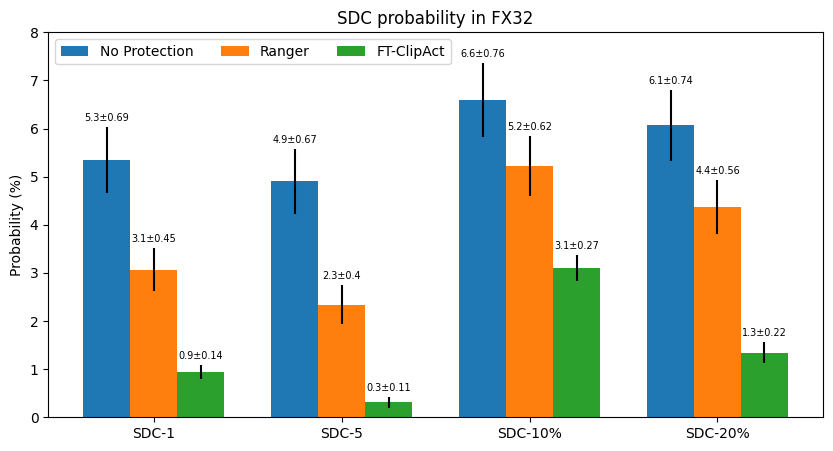

In [14]:
sdcs = {
    'No Protection': [
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc1']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc5']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc10p']),
        mean_confidence_interval(injected_data.loc[injected_data['dtype'] == 'FX32']['sdc20p']),
    ],
    'Ranger': [
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FX32']['sdc1']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FX32']['sdc5']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FX32']['sdc10p']),
        mean_confidence_interval(ranger_output.loc[injected_data['dtype'] == 'FX32']['sdc20p']),
    ],
    'FT-ClipAct': [
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FX32']['sdc1']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FX32']['sdc5']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FX32']['sdc10p']),
        mean_confidence_interval(clipact_output.loc[injected_data['dtype'] == 'FX32']['sdc20p']),
    ]
}

plt.figure(figsize=(10, 5))
plt.subplot()
width = 0.25

for i, (key, val) in enumerate(sdcs.items()):
    offset = width * i
    rects = plt.bar(np.arange(4) + offset, [m[0] for m in val], width, label=key, yerr=[np.round(m[1], 2) for m in val])
    plt.bar_label(rects, labels=['{}±{}'.format(np.round(m[0], 1), np.round(m[1], 2)) for m in val], fontsize=7, padding=3)

plt.ylabel('Probability (%)')
plt.title('SDC probability in FX32')
plt.xticks(np.arange(4) + width, ['SDC-1', 'SDC-5', 'SDC-10%', 'SDC-20%'])
plt.legend(loc='upper left', ncols=3)
plt.ylim(0, 8)

plt.show()

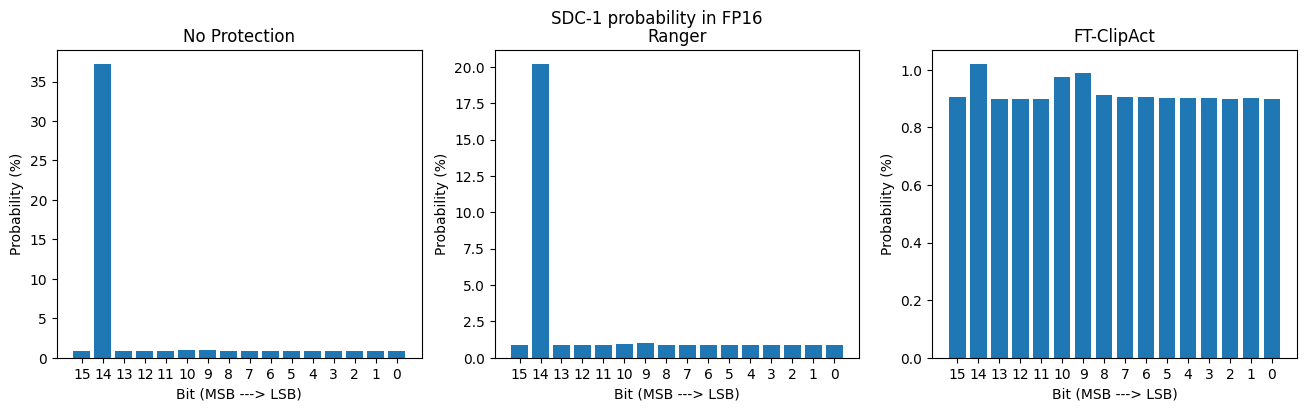

In [15]:
types_16 = np.arange(0, 16)
default_means = []
ranger_means = []
clipact_means = []
for i in types_16:
    mean_default_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FP16') & (injected_data['bit_position'] == i)]['sdc1'])
    default_means.append(mean_default_1)

    mean_ranger_1, h = mean_confidence_interval(ranger_output.loc[(injected_data['dtype'] == 'FP16') & (injected_data['bit_position'] == i)]['sdc1'])
    ranger_means.append(mean_ranger_1)

    mean_clipact_1, h = mean_confidence_interval(clipact_output.loc[(injected_data['dtype'] == 'FP16') & (injected_data['bit_position'] == i)]['sdc1'])
    clipact_means.append(mean_clipact_1)

plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title('No Protection')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar((np.array(list(reversed(types_16)))).astype(str), default_means)

plt.subplot(132)
plt.title('Ranger')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar((np.array(list(reversed(types_16)))).astype(str), ranger_means)

plt.subplot(133)
plt.title('FT-ClipAct')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar((np.array(list(reversed(types_16)))).astype(str), clipact_means)

plt.suptitle('SDC-1 probability in FP16')
plt.show()

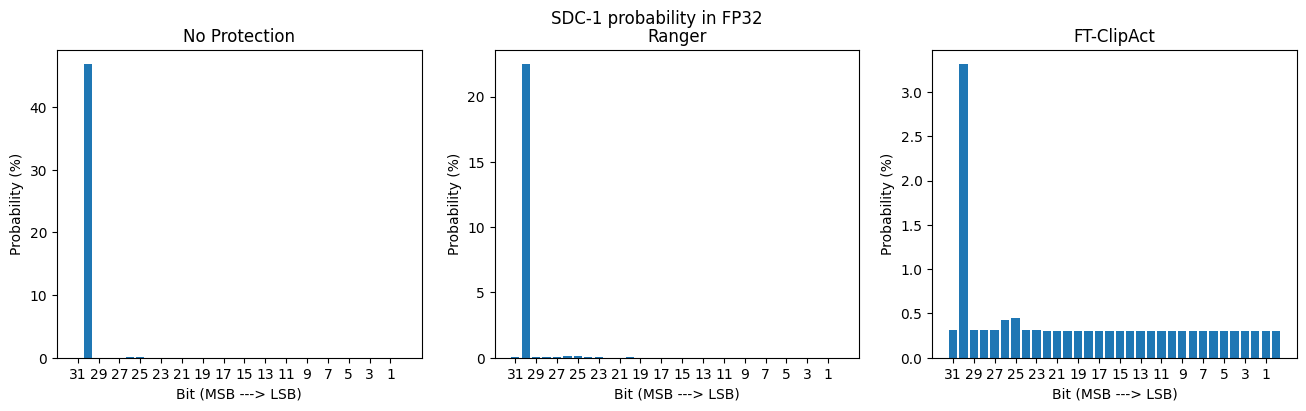

In [16]:
types_32 = np.arange(0, 32)
default_means = []
ranger_means = []
clipact_means = []
for i in types_32:
    mean_default_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FP32') & (injected_data['bit_position'] == i)]['sdc1'])
    default_means.append(mean_default_1)

    mean_ranger_1, h = mean_confidence_interval(ranger_output.loc[(injected_data['dtype'] == 'FP32') & (injected_data['bit_position'] == i)]['sdc1'])
    ranger_means.append(mean_ranger_1)

    mean_clipact_1, h = mean_confidence_interval(clipact_output.loc[(injected_data['dtype'] == 'FP32') & (injected_data['bit_position'] == i)]['sdc1'])
    clipact_means.append(mean_clipact_1)

plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title('No Protection')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar(types_32, default_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))

plt.subplot(132)
plt.title('Ranger')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar(types_32, ranger_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))

plt.subplot(133)
plt.title('FT-ClipAct')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar(types_32, clipact_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))

plt.suptitle('SDC-1 probability in FP32')
plt.show()


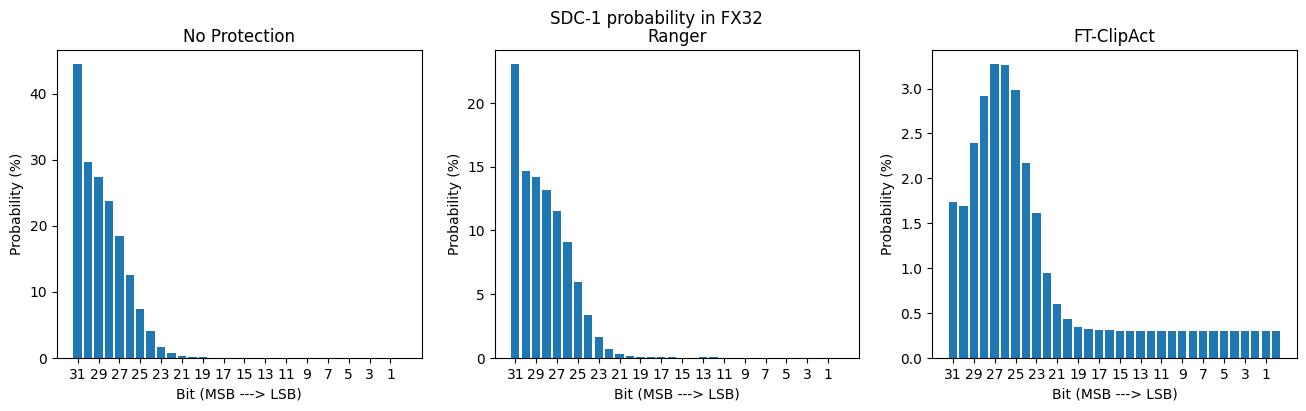

In [17]:
types_32 = np.arange(0, 32)
default_means = []
ranger_means = []
clipact_means = []
for i in types_32:
    mean_default_1, h = mean_confidence_interval(injected_data.loc[(injected_data['dtype'] == 'FX32') & (injected_data['bit_position'] == i)]['sdc1'])
    default_means.append(mean_default_1)

    mean_ranger_1, h = mean_confidence_interval(ranger_output.loc[(injected_data['dtype'] == 'FX32') & (injected_data['bit_position'] == i)]['sdc1'])
    ranger_means.append(mean_ranger_1)

    mean_clipact_1, h = mean_confidence_interval(clipact_output.loc[(injected_data['dtype'] == 'FX32') & (injected_data['bit_position'] == i)]['sdc1'])
    clipact_means.append(mean_clipact_1)

plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title('No Protection')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar(types_32, default_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))

plt.subplot(132)
plt.title('Ranger')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar(types_32, ranger_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))

plt.subplot(133)
plt.title('FT-ClipAct')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Probability (%)')
plt.bar(types_32, clipact_means)
plt.xticks(np.arange(0, 32, 2), np.arange(31, -1, -2))

plt.suptitle('SDC-1 probability in FX32')
plt.show()


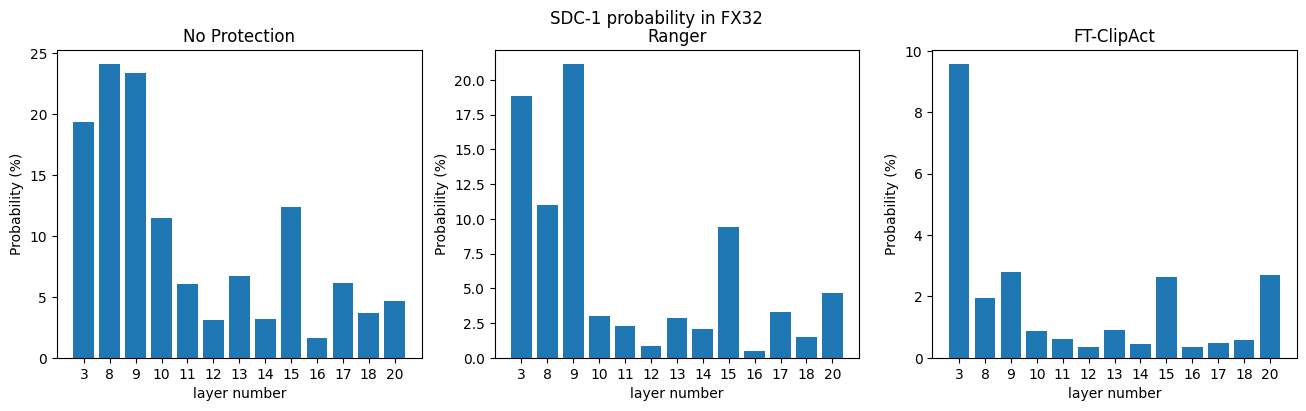

In [33]:
layers_param = layers_params_number(inception, [3, 299, 299])

total_layers = OrderedDict()
for key, bound in layers_param.items():
    new_key = key[1].split('.')[1]
    total_layers[new_key] = bound
    
default_means = OrderedDict()
ranger_means = OrderedDict()
clipact_means = OrderedDict()
prev_bound = 0
for i, (key, bound) in enumerate(total_layers.items()):
    selected = injected_data.loc[(injected_data['dtype'] == 'FX32') & (injected_data['param_number'] <= bound) & (injected_data['param_number'] >= prev_bound)]['sdc1']
    if len(selected.index) != 0:
        default_means[i+1] = mean_confidence_interval(selected)[0]

    selected = ranger_output.loc[(injected_data['dtype'] == 'FX32') & (injected_data['param_number'] <= bound) & (injected_data['param_number'] >= prev_bound)]['sdc1']
    if len(selected.index) != 0:
        ranger_means[i+1] = mean_confidence_interval(selected)[0]

    selected = clipact_output.loc[(injected_data['dtype'] == 'FX32') & (injected_data['param_number'] <= bound) & (injected_data['param_number'] >= prev_bound)]['sdc1']
    if len(selected.index) != 0:
        clipact_means[i+1] = mean_confidence_interval(selected)[0]
    prev_bound = bound


plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title('No Protection')
plt.xlabel('layer number')
plt.ylabel('Probability (%)')
layers_asstr = np.array(list(default_means.keys())).astype(str)
plt.bar(layers_asstr, default_means.values())

plt.subplot(132)
plt.title('Ranger')
plt.xlabel('layer number')
plt.ylabel('Probability (%)')
layers_asstr = np.array(list(ranger_means.keys())).astype(str)
plt.bar(layers_asstr, ranger_means.values())

plt.subplot(133)
plt.title('FT-ClipAct')
plt.xlabel('layer number')
plt.ylabel('Probability (%)')
layers_asstr = np.array(list(clipact_means.keys())).astype(str)
plt.bar(layers_asstr, clipact_means.values())

plt.suptitle('SDC-1 probability in FX32')
plt.show()


In [9]:
def detector_stat(detector_outputs, injected_outputs, main_outputs):

    injected_sdc = OrderedDict()
    for injection, value in injected_outputs.items():
        injected_sdc[injection] = (value[0] == main_outputs[:, 0])
    
    detector_sdc = OrderedDict()
    for injection, value in detector_outputs.items():
        detector_sdc[injection] = (value[0] == main_outputs[:, 0])
    
    detector_stat = pd.DataFrame(columns=['TP', 'FP', 'TN', 'FN'])
    for injection in detector_sdc.keys():
        injected_sdc_not = torch.logical_not(injected_sdc[injection])
        TP = torch.logical_and(injected_sdc_not, detector_sdc[injection]).type(torch.float32).sum().item()
        FN = torch.logical_not(torch.logical_or(injected_sdc[injection], detector_sdc[injection])).type(torch.float32).sum().item()
        TN = torch.logical_and(injected_sdc[injection], detector_sdc[injection]).type(torch.float32).sum().item()
        FP = len(torch.flatten(injected_sdc_not)) - TP - FN - TN
        detector_stat.loc[injection] = [TP, FP, TN, FN]
    
    detector_stat['accuracy'] = (detector_stat['TP'] + detector_stat['TN']) / len(torch.flatten(injected_sdc_not)) * 100
    detector_stat['precision'] = (detector_stat['TP'] / (detector_stat['TP'] + detector_stat['FP'])) * 100
    detector_stat['recall'] = (detector_stat['TP'] / (detector_stat['TP'] + detector_stat['FN'])) * 100

    total_stat = OrderedDict()
    total_stat['accuracy'] = (detector_stat['TP'].mean() + detector_stat['TN'].mean()) / len(torch.flatten(injected_sdc_not)) * 100
    total_stat['precision'] = (detector_stat['TP'].sum() / (detector_stat['TP'].sum() + detector_stat['FP'].sum())) * 100
    total_stat['recall'] = (detector_stat['TP'].sum() / (detector_stat['TP'].sum() + detector_stat['FN'].sum())) * 100

    return detector_stat, total_stat


In [10]:
ranger_stat, ranger_total = detector_stat(ranger_output['output'][3168:6336], injected_data['output'][3168:6336], main_data['float32'][0])
clipact_stat, clipact_total = detector_stat(clipact_output['output'][3168:6336], injected_data['output'][3168:6336], main_data['float32'][0])

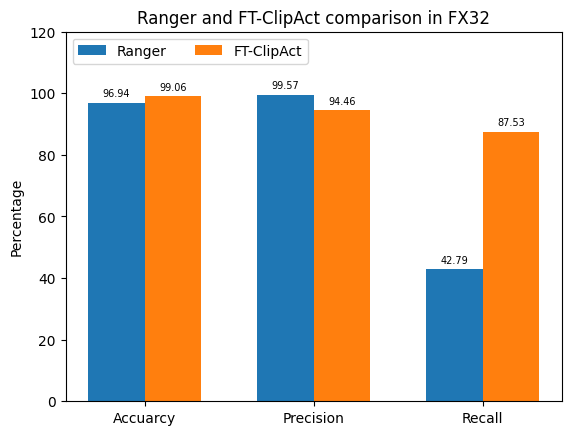

In [36]:
stats = {
    'Ranger': [
        ranger_total['accuracy'],
        ranger_total['precision'],
        ranger_total['recall'],
    ],
    'FT-ClipAct': [
        clipact_total['accuracy'],
        clipact_total['precision'],
        clipact_total['recall'],
    ]
}

plt.figure()
plt.subplot()
width = 1 / 3

for i, (key, val) in enumerate(stats.items()):
    offset = width * i
    rects = plt.bar(np.arange(3) + offset, val, width, label=key)
    plt.bar_label(rects, labels=['{}'.format(np.round(m, 2)) for m in val], fontsize=7, padding=3)

plt.ylabel('Percentage')
plt.title('Ranger and FT-ClipAct comparison in FX32')
plt.xticks(np.arange(3) + width / 2, ['Accuarcy', 'Precision', 'Recall'])
plt.legend(loc='upper left', ncols=2)
plt.ylim(0, 120)

plt.show()

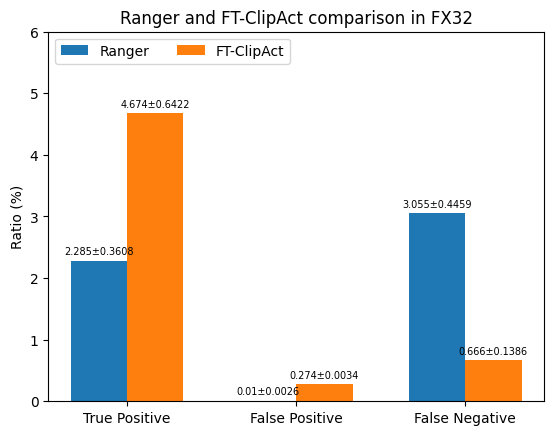

In [11]:
stats = {
    'Ranger': [
        mean_confidence_interval(ranger_stat.loc[injected_data['dtype'] == 'FX32']['TP'] / 10),
        mean_confidence_interval(ranger_stat.loc[injected_data['dtype'] == 'FX32']['FP'] / 10),
        mean_confidence_interval(ranger_stat.loc[injected_data['dtype'] == 'FX32']['FN'] / 10),
    ],
    'FT-ClipAct': [
        mean_confidence_interval(clipact_stat.loc[injected_data['dtype'] == 'FX32']['TP'] / 10),
        mean_confidence_interval(clipact_stat.loc[injected_data['dtype'] == 'FX32']['FP'] / 10),
        mean_confidence_interval(clipact_stat.loc[injected_data['dtype'] == 'FX32']['FN'] / 10),
    ]
}

plt.figure()
plt.subplot()
width = 1 / 3

for i, (key, val) in enumerate(stats.items()):
    offset = width * i
    rects = plt.bar(np.arange(3) + offset, [m[0] for m in val], width, label=key)
    plt.bar_label(rects, labels=['{}±{}'.format(np.round(m[0], 3), np.round(m[1], 4)) for m in val], fontsize=7, padding=3)

plt.ylabel('Ratio (%)')
plt.title('Ranger and FT-ClipAct comparison in FX32')
plt.xticks(np.arange(3) + width / 2, ['True Positive', 'False Positive', 'False Negative'])
plt.legend(loc='upper left', ncols=3)
plt.ylim(0, 6)

plt.show()

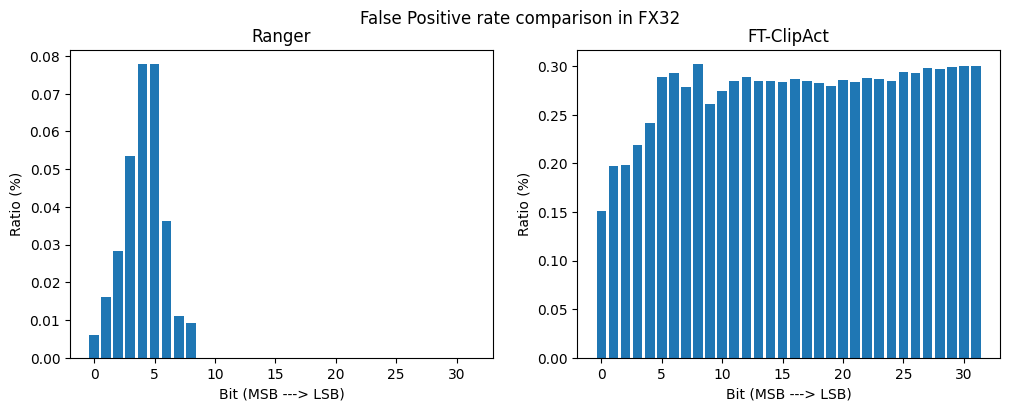

In [38]:
types_32 = np.arange(0, 32)
ranger_means = []
clipact_means = []
for i in types_32:
    mean_ranger_1, h = mean_confidence_interval(ranger_stat.loc[(injected_data['dtype'] == 'FX32') & (injected_data['bit_position'] == i)]['FP'] / 10)
    ranger_means.append(mean_ranger_1)

    mean_clipact_1, h = mean_confidence_interval(clipact_stat.loc[(injected_data['dtype'] == 'FX32') & (injected_data['bit_position'] == i)]['FP'] / 10)
    clipact_means.append(mean_clipact_1)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.title('Ranger')
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Ratio (%)')
plt.bar(types_32, ranger_means)

plt.subplot(122)
plt.title('FT-ClipAct')
plt.bar(types_32, clipact_means)
plt.xlabel('Bit (MSB ---> LSB)')
plt.ylabel('Ratio (%)')

plt.suptitle('False Positive rate comparison in FX32')
plt.show()


Tests with real classes

In [99]:
def test(inception, testloader, params_range, tuned_params_range):

  test_result = OrderedDict()

  size = len(testloader.dataset)
  inception.eval()
  correct = 0
  runtime = 0
  with torch.no_grad():
      for X, y in testloader:
          X, y = X.to(DEVICE), y.to(DEVICE)
          start = time()
          pred = inception(X)
          runtime += time() - start
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  correct /= size
  test_result['default'] = [100 * correct, runtime]
  print('default ', test_result['default'])

  hooks = ranger(inception, params_range, None, [3, 299, 299])

  inception.eval()
  correct = 0
  runtime = 0
  with torch.no_grad():
      for X, y in testloader:
          X, y = X.to(DEVICE), y.to(DEVICE)
          start = time()
          pred = inception(X)
          runtime += time() - start
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  correct /= size

  for hook in hooks:
    hook.remove()
  test_result['ranger'] = [100 * correct, runtime]
  print('ranger ', test_result['ranger'])

  hooks = bound_activations(inception, tuned_params_range, None, [3, 299, 299])

  inception.eval()
  correct = 0
  runtime = 0
  with torch.no_grad():
      for X, y in testloader:
          X, y = X.to(DEVICE), y.to(DEVICE)
          start = time()
          pred = inception(X)
          runtime += time() - start
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  correct /= size

  for hook in hooks:
    hook.remove()
  test_result['clipact'] = [100 * correct, runtime]
  print('clipact', test_result['clipact'])

  return test_result


In [100]:
test_result = test(inception, testloader, params_range, tuned_params_range)

default  [70.8, 93.97921371459961]
ranger  [70.7, 122.83242654800415]
clipact [70.8, 111.88055968284607]


In [9]:
def top1(injected_outputs: pd.Series, main_outputs: torch.Tensor):
    sdcs = {}
    testset_length = main_outputs.__len__()
    for injection, value in injected_outputs.items():
        sdcs[injection] = (value[0] == main_outputs[:, 0]).type(torch.float).sum().item() * 100 / testset_length
    return pd.Series(sdcs)

In [14]:
real_classes = torch.tensor([], dtype=torch.int)
for _, y in testloader:
    real_classes = torch.cat((real_classes, y.unsqueeze(1)))

top1_injected = top1(injected_data['output'], real_classes)
top1_ranger = top1(ranger_output['output'], real_classes)
top1_clipact = top1(clipact_output['output'], real_classes)


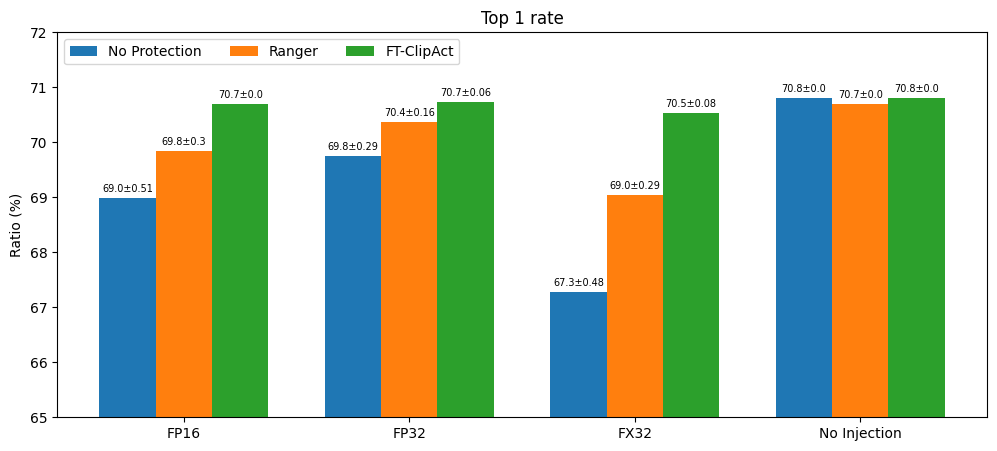

In [25]:
top1s = {
    'No Protection': [
        mean_confidence_interval(top1_injected.loc[injected_data['dtype'] == 'FP16']),
        mean_confidence_interval(top1_injected.loc[injected_data['dtype'] == 'FP32']),
        mean_confidence_interval(top1_injected.loc[injected_data['dtype'] == 'FX32']),
        (70.8, 0.0),
    ],
    'Ranger': [
        mean_confidence_interval(top1_ranger.loc[injected_data['dtype'] == 'FP16']),
        mean_confidence_interval(top1_ranger.loc[injected_data['dtype'] == 'FP32']),
        mean_confidence_interval(top1_ranger.loc[injected_data['dtype'] == 'FX32']),
        (70.7, 0.0),
    ],
    'FT-ClipAct': [
        mean_confidence_interval(top1_clipact.loc[injected_data['dtype'] == 'FP16']),
        mean_confidence_interval(top1_clipact.loc[injected_data['dtype'] == 'FP32']),
        mean_confidence_interval(top1_clipact.loc[injected_data['dtype'] == 'FX32']),
        (70.8, 0.0),
    ]
}

plt.figure(figsize=(12, 5))
plt.subplot()

width = 0.25

for i, (key, val) in enumerate(top1s.items()):
    offset = width * i
    rects = plt.bar(np.arange(4) + offset, [m[0] for m in val], width, label=key)
    plt.bar_label(rects, labels=['{}±{}'.format(np.round(m[0], 1), np.round(m[1], 2)) for m in val], fontsize=7, padding=3)

plt.ylabel('Ratio (%)')
plt.title('Top 1 rate')
plt.xticks(np.arange(4) + width, ['FP16', 'FP32', 'FX32', 'No Injection'])
plt.legend(loc='upper left', ncols=3)
plt.ylim(65, 72)

plt.show()

In [21]:
for i, value in enumerate(layers_params_number(inception, [3, 299, 299]).items()):
    print(i, value)

0 ((2, 'inception.Conv2d_1a_3x3.relu'), 993)
1 ((5, 'inception.Conv2d_2a_3x3.relu'), 10338)
2 ((8, 'inception.Conv2d_2b_3x3.relu'), 29027)
3 ((9, 'inception.maxpool1'), 29027)
4 ((12, 'inception.Conv2d_3b_1x1.relu'), 34468)
5 ((15, 'inception.Conv2d_4a_3x3.relu'), 173477)
6 ((16, 'inception.maxpool2'), 173477)
7 ((19, 'inception.Mixed_5b.branch1x1.relu'), 186022)
8 ((22, 'inception.Mixed_5b.branch5x5_1.relu'), 195431)
9 ((25, 'inception.Mixed_5b.branch5x5_2.relu'), 272488)
10 ((28, 'inception.Mixed_5b.branch3x3dbl_1.relu'), 285033)
11 ((31, 'inception.Mixed_5b.branch3x3dbl_2.relu'), 340714)
12 ((34, 'inception.Mixed_5b.branch3x3dbl_3.relu'), 424043)
13 ((35, 'inception.Mixed_5b.avgpool'), 424043)
14 ((38, 'inception.Mixed_5b.branch_pool.relu'), 430316)
15 ((41, 'inception.Mixed_5c.branch1x1.relu'), 446957)
16 ((44, 'inception.Mixed_5c.branch5x5_1.relu'), 459438)
17 ((47, 'inception.Mixed_5c.branch5x5_2.relu'), 536495)
18 ((50, 'inception.Mixed_5c.branch3x3dbl_1.relu'), 553136)
19 ((53,